In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_pickle("data/bikes_limpieza.pkl")
df.head(2)

,fecha,estacion,año,mes,festivo,dia,laborable,meteo,temperatura,sensacion_termica,humedad,velo_viento,usu_casuales,usu_registrados,total_alquiler
0,2018-01-01,invierno,2018,ene,festivo,lun,no laborable,nublado,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2018-01-02,invierno,2018,ene,no festivo,mar,laborable,nublado,14.902598,17.68695,69.6087,16.652113,131,670,801


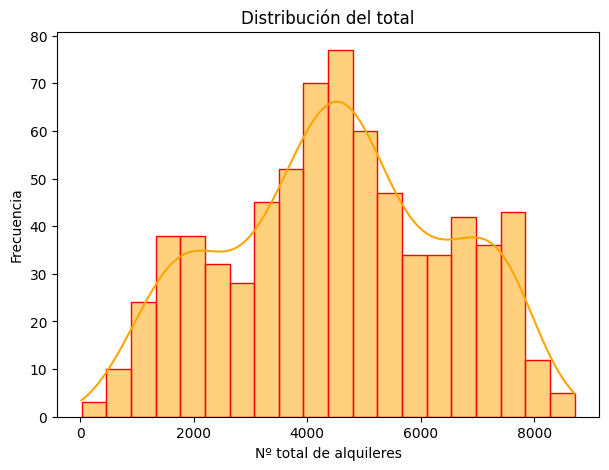

In [3]:
plt.figure(figsize=(7, 5))

sns.histplot(df["total_alquiler"], bins=20, color="orange", edgecolor="red", kde=True)

plt.title("Distribución del total")
plt.xlabel("Nº total de alquileres")
plt.ylabel("Frecuencia")
plt.show()   #distribución variable respuesta

`ESTO LO COMPROBAMOS AQUÍ O EN OTRO JUPYTER DE ASUNCIONES?`
A nivel visual, parece que nuestra VR no es normal. Vamos a comprobarlo con un Shapiro (nuestros datos son < 5000).

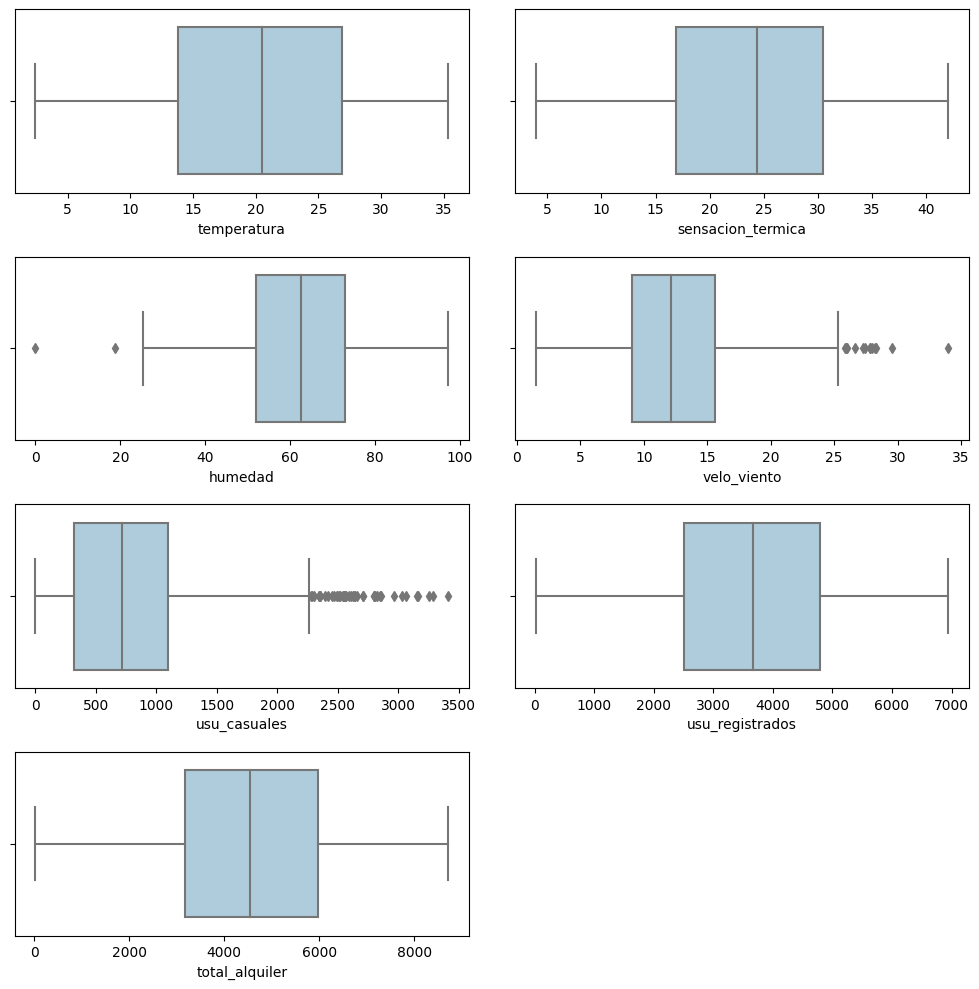

In [4]:
numericas = df.select_dtypes(include=['int64', 'float64'])

fig, axes = plt.subplots(4, 2, figsize=(10,10))
axes = axes.flat
for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = numericas[columna], data = df, ax = axes[indice], palette = "Paired");
plt.tight_layout()
fig.delaxes(axes[-1])
plt.show()    #chequeo de outliers

A la vista de los outliers, mantendríamos todos (por ser valores que parecen reales), salvo en el caso de "humedad" (hemos revisado que estos datos son extremadamente improbables). Vamos a ver quiénes son esos outliers:

In [5]:
df[df["humedad"] < 20]

,fecha,estacion,año,mes,festivo,dia,laborable,meteo,temperatura,sensacion_termica,humedad,velo_viento,usu_casuales,usu_registrados,total_alquiler
49,2018-02-19,invierno,2018,feb,festivo,lun,no laborable,buen tiempo,16.365847,19.5702,18.7917,34.000021,532,1103,1635
68,2018-03-10,invierno,2018,mar,no festivo,sab,no laborable,ligeramente mal tiempo,15.952731,19.2834,0.0000,17.545759,46,577,623


`CAMBIO DE OUTLIERS`
A la vista de estos valores, hemos decidido reemplazar estos dos outliers por la temperatura mediana dentro de ese mismo mes de ese mismo año y para el mismo tipo de día (los datos de climatología histórica para Washington que hemos encontrado en internet no nos cuadraban con los del dataframe):
- En el caso del 2018-02-19, sacaremos la mediana  de 2018 de días con buen tiempo (hay 19 registros).
- En el caso del 2018-03-10, sacaremos la mediana de marzo de 2018 de días con ligeramente mal tiempo (en este caso, además, la media y la mediana son las mismas).

In [25]:
mediana_humedad = df[(df["año"] == 2018) & (df["meteo"] == "buen tiempo")]["humedad"].median()

In [26]:
df.loc[df["fecha"] == "2018-02-19", "humedad"] = mediana_humedad

In [30]:
df.loc[df["fecha"] == "2018-03-10", "humedad"] = df[(df["año"] == 2018) & (df["meteo"] == "ligeramente mal tiempo")]["humedad"].median()

Vamos a comprobar las relaciones entre las VP numéricas y la VR:

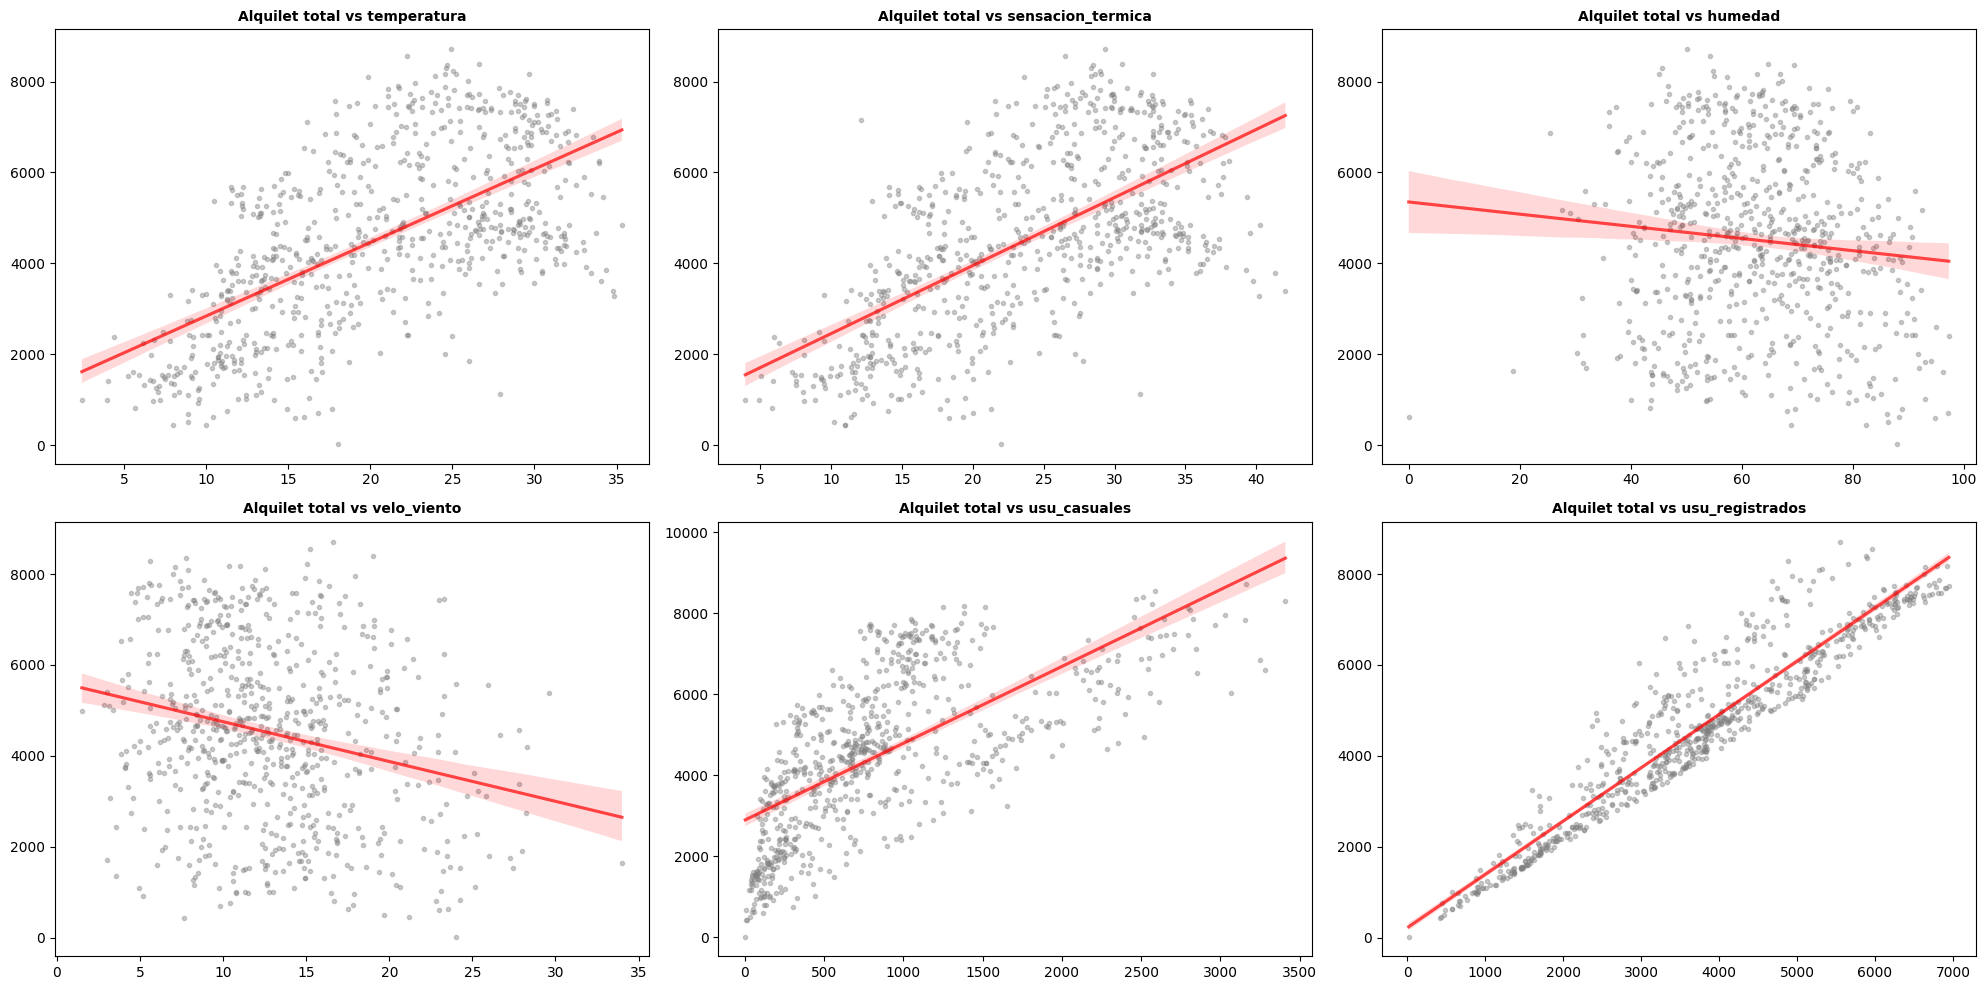

In [11]:
fig, axes = plt.subplots(2, 3, figsize = (20, 10))

axes = axes.flat

columnas_numeric = numericas.columns
columnas_numeric = columnas_numeric.drop("total_alquiler")

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df[colum], 
        y = df["total_alquiler"], 
        color = "gray", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Alquilet total vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
fig.tight_layout();

Comprobamos la normalidad de cada VP numérica


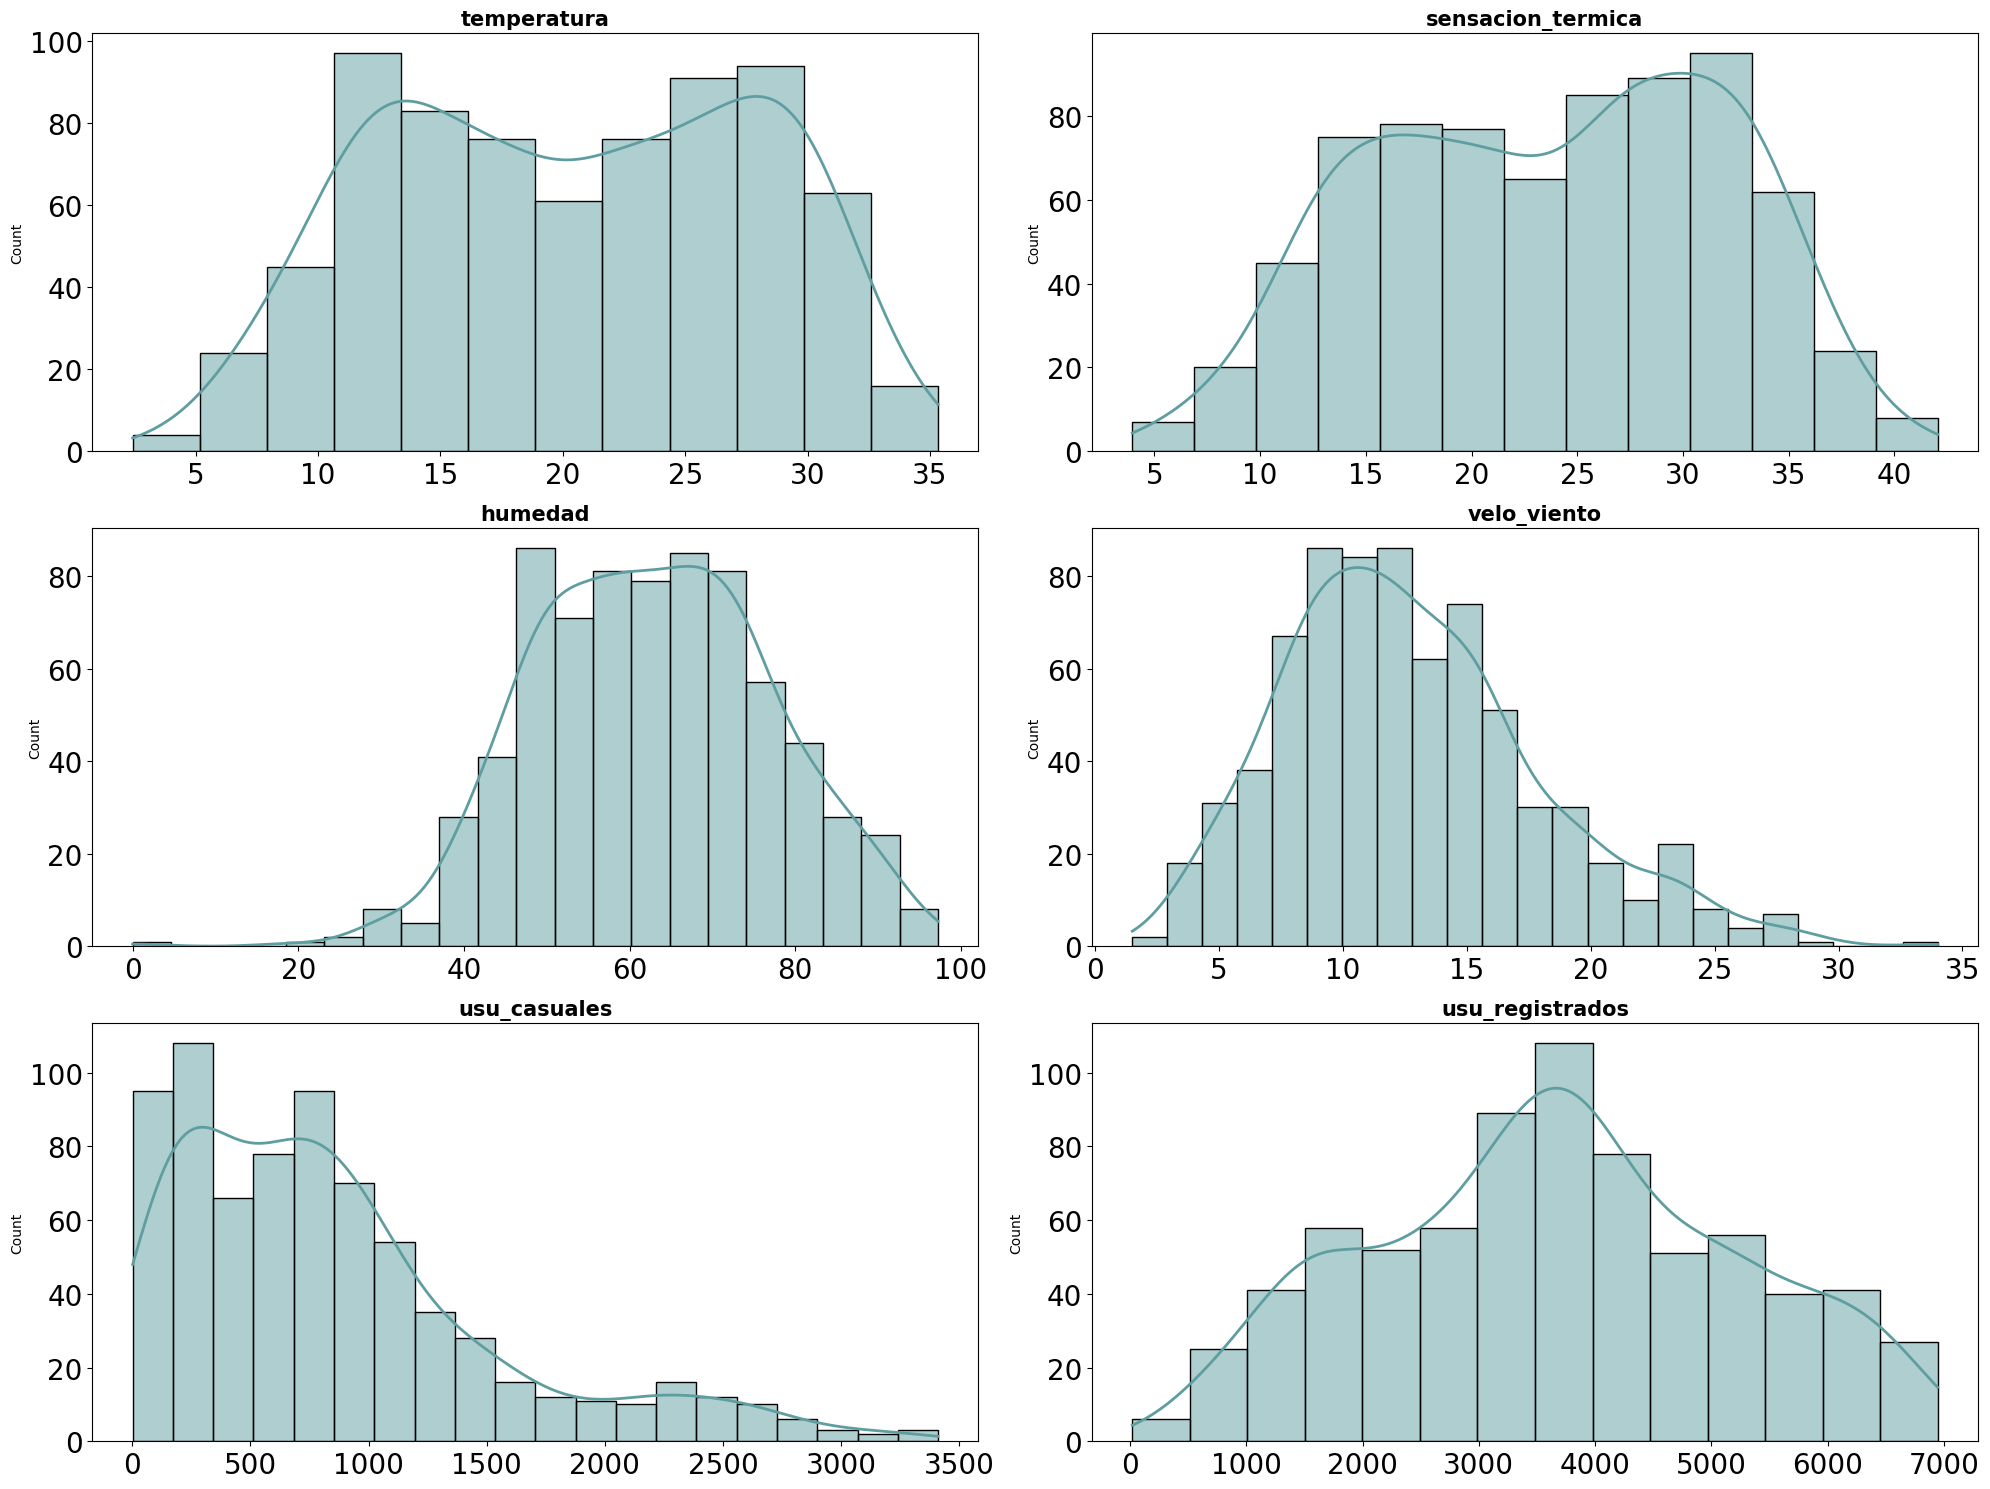

In [17]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 15))
axes = axes.flat

num = df.select_dtypes(include = np.number).columns
num = num.drop("total_alquiler")

for i, colum in enumerate(num):
    sns.histplot(
        data = df,
        x = colum,
        kde = True,
        color = "cadetblue",
        line_kws = {"linewidth": 2},
        alpha = 0.5,
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    fig.tight_layout();

Calculo correlación de variables numéricas

In [13]:
df_numericas = df.select_dtypes(include = np.number)


In [14]:
df_numericas.cov()


,temperatura,sensacion_termica,humedad,velo_viento,usu_casuales,usu_registrados,total_alquiler
temperatura,56.350979,60.674105,13.740700,-6.169865,2796.813593,6.316089e+03,9.112903e+03
sensacion_termica,60.674105,66.427517,16.421124,-7.786743,3040.124429,6.911517e+03,9.951641e+03
humedad,13.740700,16.421124,202.708942,-18.383531,-735.102302,-1.981147e+03,-2.716250e+03
velo_viento,-6.169865,-7.786743,-18.383531,26.996761,-599.212506,-1.766034e+03,-2.365247e+03
usu_casuales,2796.813593,3040.124429,-735.102302,-599.212506,471254.618141,4.220196e+05,8.932742e+05
usu_registrados,6316.089253,6911.516931,-1981.147238,-1766.034199,422019.595513,2.432847e+06,2.854867e+06
total_alquiler,9112.902846,9951.641360,-2716.249541,-2365.246705,893274.213654,2.854867e+06,3.748141e+06


In [15]:
df_numericas.corr()


,temperatura,sensacion_termica,humedad,velo_viento,usu_casuales,usu_registrados,total_alquiler
temperatura,1.000000,0.991696,0.128565,-0.158186,0.542731,0.539436,0.627044
sensacion_termica,0.991696,1.000000,0.141512,-0.183876,0.543362,0.543678,0.630685
humedad,0.128565,0.141512,1.000000,-0.248506,-0.075211,-0.089212,-0.098543
velo_viento,-0.158186,-0.183876,-0.248506,1.000000,-0.167995,-0.217914,-0.235132
usu_casuales,0.542731,0.543362,-0.075211,-0.167995,1.000000,0.394137,0.672123
usu_registrados,0.539436,0.543678,-0.089212,-0.217914,0.394137,1.000000,0.945411
total_alquiler,0.627044,0.630685,-0.098543,-0.235132,0.672123,0.945411,1.000000


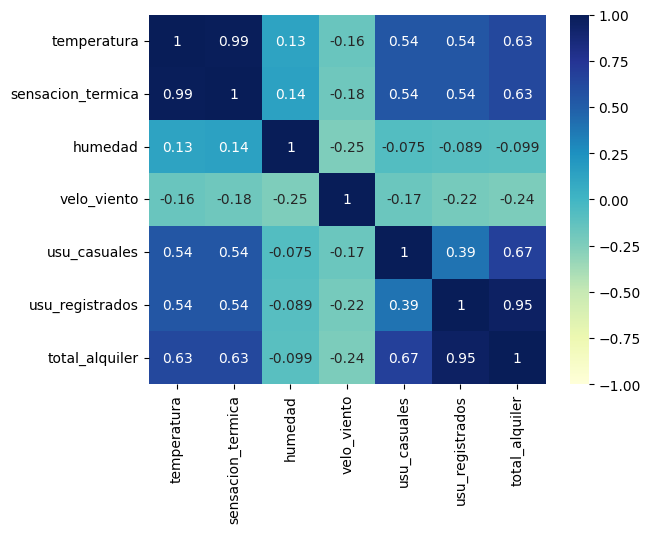

In [16]:
sns.heatmap(df_numericas.corr(), 
            cmap = "YlGnBu", 
           annot = True, vmax = 1, vmin = -1);
plt.savefig('heatmap.png', dpi = 300)

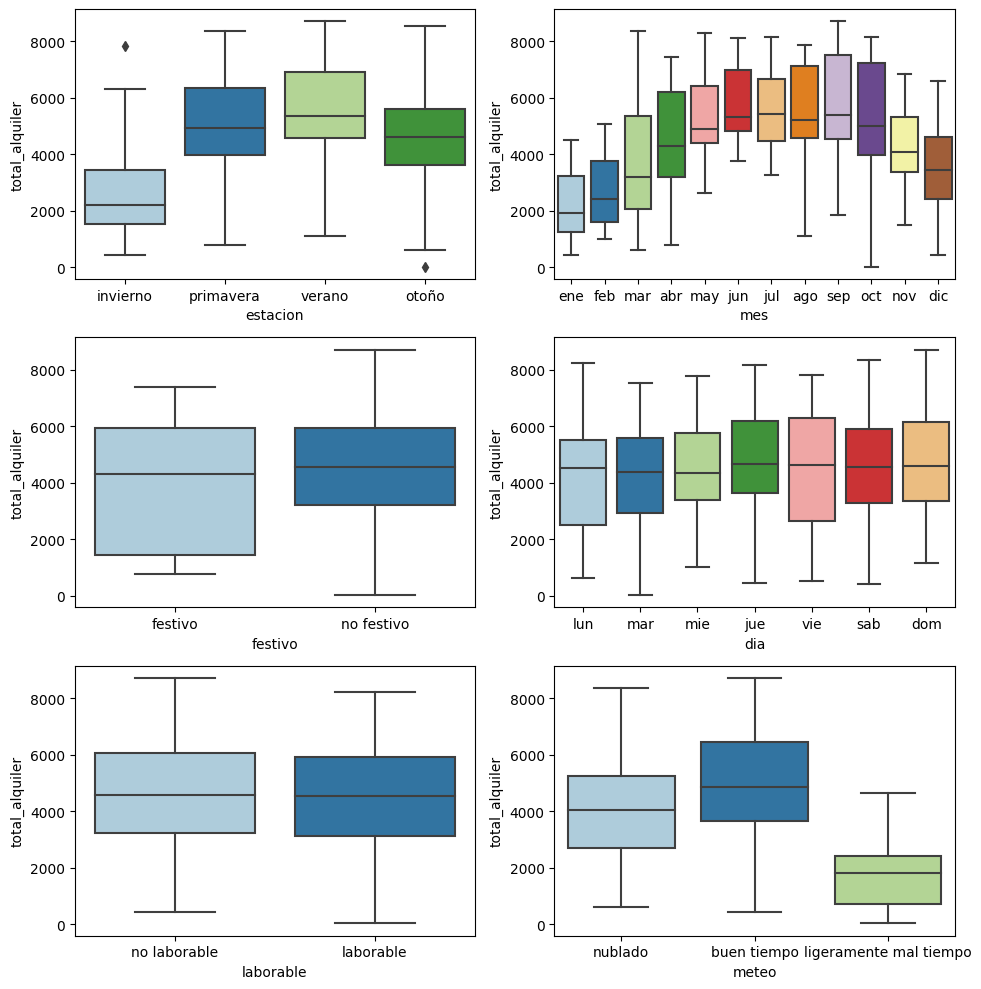

In [32]:
numericas = df.select_dtypes(include="object")

fig, axes = plt.subplots(3, 2, figsize=(10,10))
axes = axes.flat
for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = numericas[columna], y = 'total_alquiler', data = df, ax = axes[indice], palette = "Paired");
plt.tight_layout()
plt.show()  

- No tienen orden variables =  festivo, laborable, dia
- Tienen orden variables = meteo, mes, estacion

Independencia variables categóricas

In [33]:
categoricas = df.select_dtypes(include= ["object", "bool"])

distribucion = pd.crosstab(df['estacion'], df['meteo'], normalize = True)

distribucion

meteo,buen tiempo,ligeramente mal tiempo,nublado
estacion,,,
invierno,0.149315,0.005479,0.089041
otoño,0.141096,0.013699,0.089041
primavera,0.157534,0.004110,0.093151
verano,0.186301,0.005479,0.065753


In [40]:
import researchpy as rp

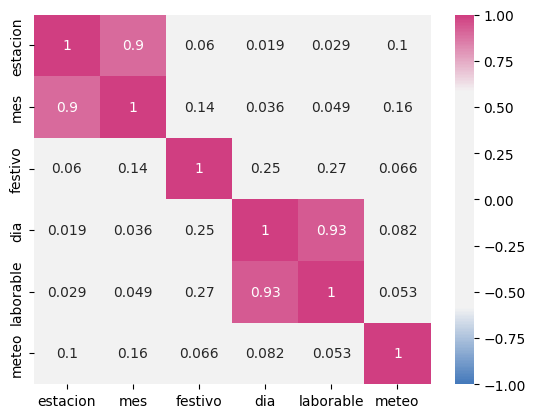

In [41]:
categoricas_col = df.select_dtypes(include= ["object", "bool"]).columns
df_chis = pd.DataFrame(columns= categoricas_col, index = categoricas_col)

from itertools import combinations
combinaciones = list(combinations(categoricas_col,2))
for i in combinaciones:
    crosstab, test_results, expected = rp.crosstab(df[i[0]], df[i[1]],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")
    df_chis.loc[i[0], i[1]] = test_results.loc[2, 'results']
    df_chis.loc[i[1], i[0]] = test_results.loc[2, 'results']
    df_chis.loc[i[0], i[0]] = 1.00
    df_chis.loc[i[1], i[1]] = 1.00
df_chis = df_chis.astype('float')
df_chis.dtypes
cmap = sns.diverging_palette(250, 349, sep=150, as_cmap=True)
sns.heatmap(df_chis,
           cmap = cmap,
           annot = True,
           vmin= -1,
           vmax= 1);